# LABORATORIUM 4 - KLASYFIKATOR SVM

### 3.1 Implementacja liniowego SVMa

In [141]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#### Funkcje do generowania zbiorów:

In [142]:
def generate_data(n_samples, n_features, random_state):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state
    )
    y = 2 * y - 1
    return X, y

def generate_moons(n_samples, random_state):
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    y_moons = 2 * y_moons - 1
    return X_moons, y_moons

#### Funkcje do liczenia metryk i statystyk:

In [143]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

def evaluate_classifier(y_test, y_pred, X, y, model, classifier_name, dataset_name, labels=[0,1], decision_plot=True):
    # Oblicz metryki
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Wyświetl metryki
    print(f"{classifier_name} na {dataset_name}:")
    print(f"Skuteczność: {accuracy*100:.4f}%")
    print(f"Czułość (Recall): {sensitivity*100:.4f}%")
    print(f"Swoistość: {specificity*100:.4f}%")
    print(f"ROC AUC: {roc_auc:.4f}")

    fig = plt.figure(figsize=(20, 6))
    plt.suptitle(f"WYNIKI DLA: {classifier_name} na zbiorze: {dataset_name}", fontsize=16, y=1.05)

    axes = fig.subplots(1, 3)

    # Macierz pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=axes[0], cmap='Greens', colorbar=False)
    axes[0].set_title("Macierz pomyłek")

    # Krzywa ROC
    axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--') 
    axes[1].set_xlabel('1 - Swoistość (False Positive Rate)')
    axes[1].set_ylabel('Czułość (True Positive Rate)')
    axes[1].set_title('Krzywa ROC')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    if decision_plot:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        custom_cmap = ListedColormap(['red', 'blue'])
        axes[2].contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
        scatter = axes[2].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=custom_cmap, s=50)
        axes[2].set_title("Granica decyzyjna")
        axes[2].set_xlabel("Feature 1")
        axes[2].set_ylabel("Feature 2")
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()


#### Właśna implementacja SVM:

In [144]:
from scipy.optimize import minimize

class SVM_Linear: 
    def __init__(self, learning_rate=0.001):
        self.lr = learning_rate
        self.w = None
        self.b = None
        self.lambdas = None

    def dual_svm(self, lambdas, X, y):
        K = X @ X.T
        L = np.outer(lambdas, lambdas)
        Y = np.outer(y, y)
        return -np.sum(lambdas) + 0.5 * np.sum(L * Y * K)
        
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        ## ograniczenia:
        bounds = [(0, None) for _ in range(n_samples)] ## lambda >= 0
        constraints = {'type': 'eq', 'fun': lambda l: np.dot(l, y)} ## suma lambd @ y musi być równa 0

        init_lambdas = np.random.rand(n_samples)

        result = minimize(
            fun=self.dual_svm,
            x0=init_lambdas,
            args=(X, y),
            bounds=bounds,
            constraints=constraints
            # method='SLSQP',
            # options={'disp': False, 'maxiter': 1000}
        )
        self.lambdas = result.x

        self.w = np.sum((self.lambdas * y).reshape(-1, 1) * X, axis=0) # aktualizacja wektora wag

        support_vectors = (self.lambdas > 1e-5) ## tylko dla punktów nośnych
        b_vals = y[support_vectors] - np.dot(X[support_vectors], self.w)
        self.b = np.mean(b_vals)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)



#### Porównanie własnej implementacji z **SVC** z biblioteki *sklearn*:

#### Własna implementacja na zbiorze *generate data* i *make moons*:

Czas wykonania: 23.402443170547485s.
Własna implementacja na Generate data:
Skuteczność: 92.5000%
Czułość (Recall): 87.5000%
Swoistość: 100.0000%
ROC AUC: 0.9375


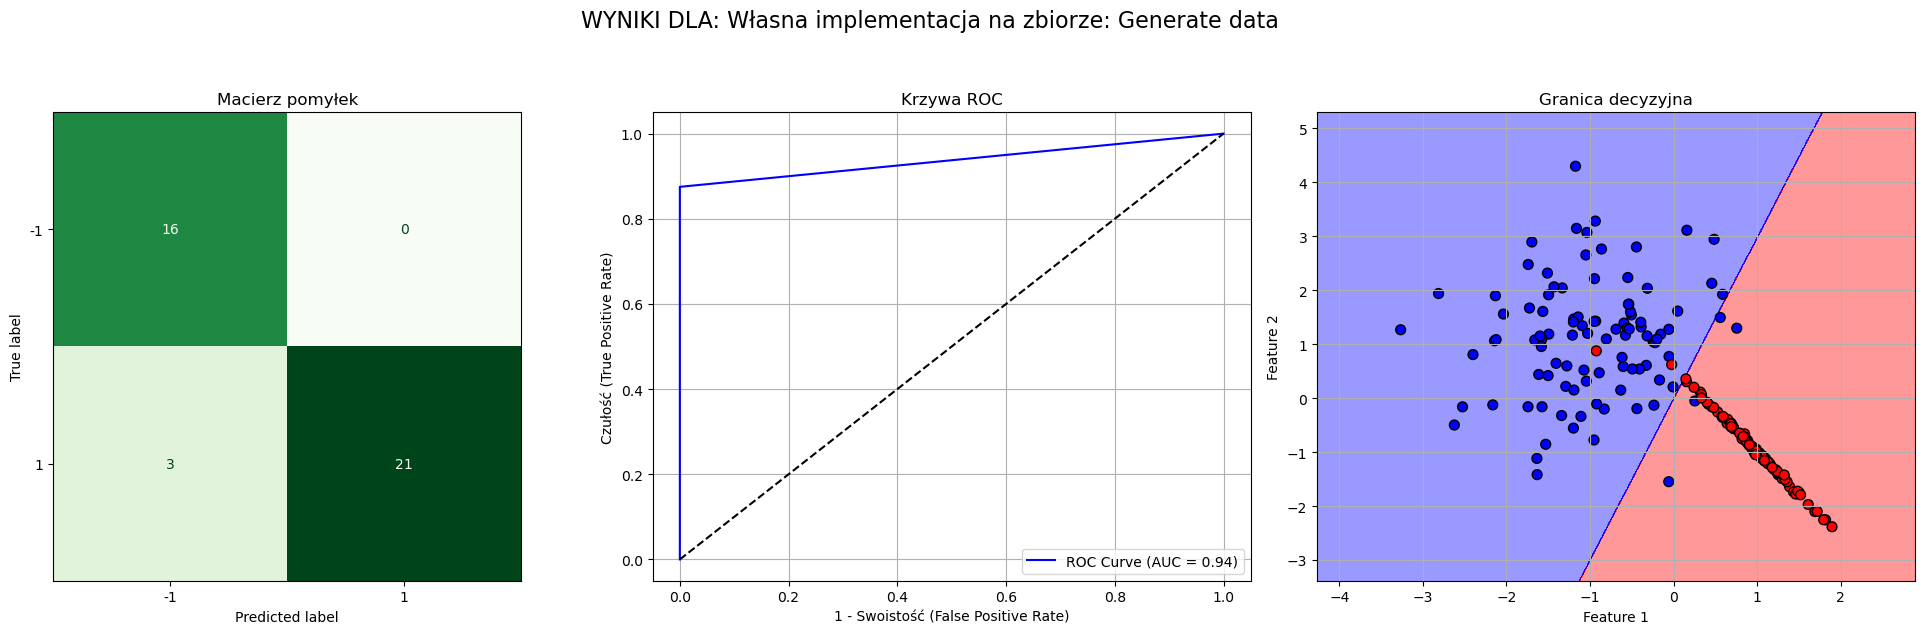

Czas wykonania: 0.00409698486328125s.
Sklearn SVC na Generate Data:
Skuteczność: 92.5000%
Czułość (Recall): 87.5000%
Swoistość: 100.0000%
ROC AUC: 0.9375


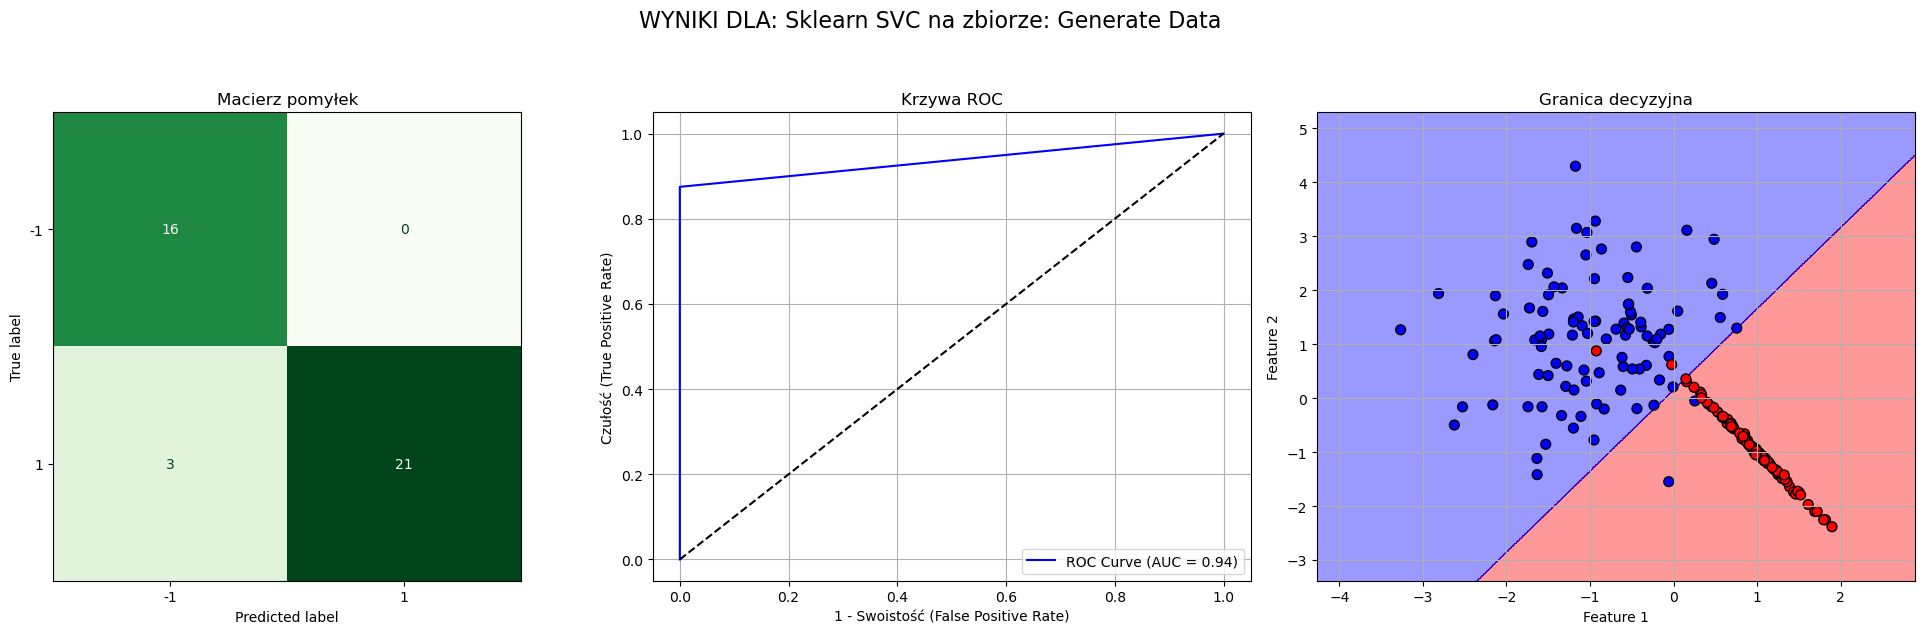

In [145]:
X_generate, y_generate = generate_data(200, 2, 259195)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_generate, y_generate, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_gen = SVM_Linear()
    svm_gen.fit(X_gen_train, y_gen_train)
    svm_generate_pred = svm_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svm_generate_pred, X_generate, y_generate, svm_gen, "Własna implementacja", "Generate data", [-1, 1])

start = time.time()
for _ in range(10):
    svc_gen = SVC(kernel='linear', random_state=259195)
    svc_gen.fit(X_gen_train, y_gen_train)
    svc_generate_pred = svc_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svc_generate_pred, X_generate, y_generate, svc_gen, "Sklearn SVC", "Generate Data", [-1, 1])


Czas wykonania: 29.597082138061523s.
Własna implementacja na Make moons:
Skuteczność: 62.5000%
Czułość (Recall): 55.5556%
Swoistość: 68.1818%
ROC AUC: 0.6187


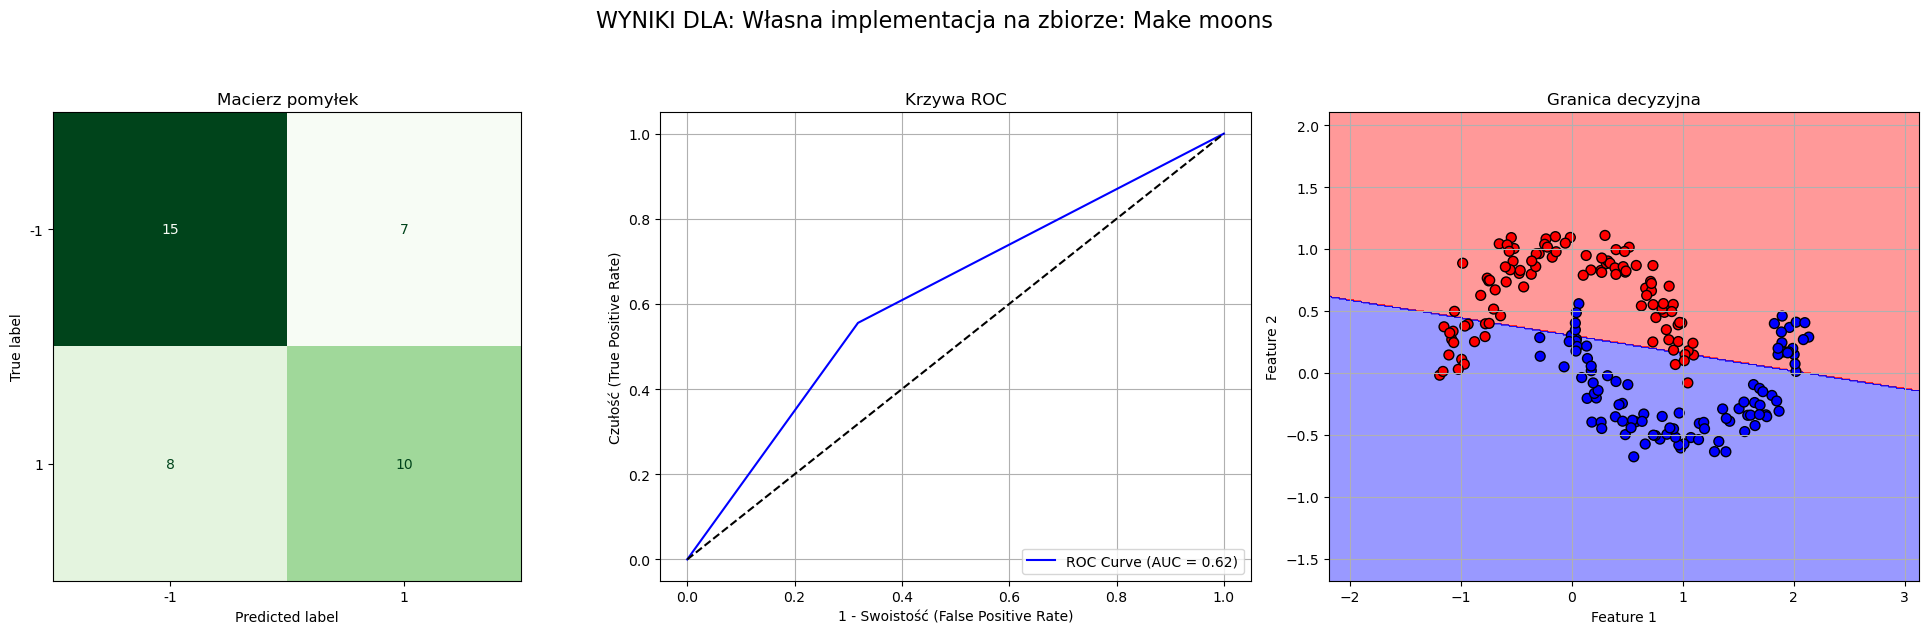

Czas wykonania: 0.010710000991821289s.
Sklearn SVC na Make moons:
Skuteczność: 87.5000%
Czułość (Recall): 88.8889%
Swoistość: 86.3636%
ROC AUC: 0.8763


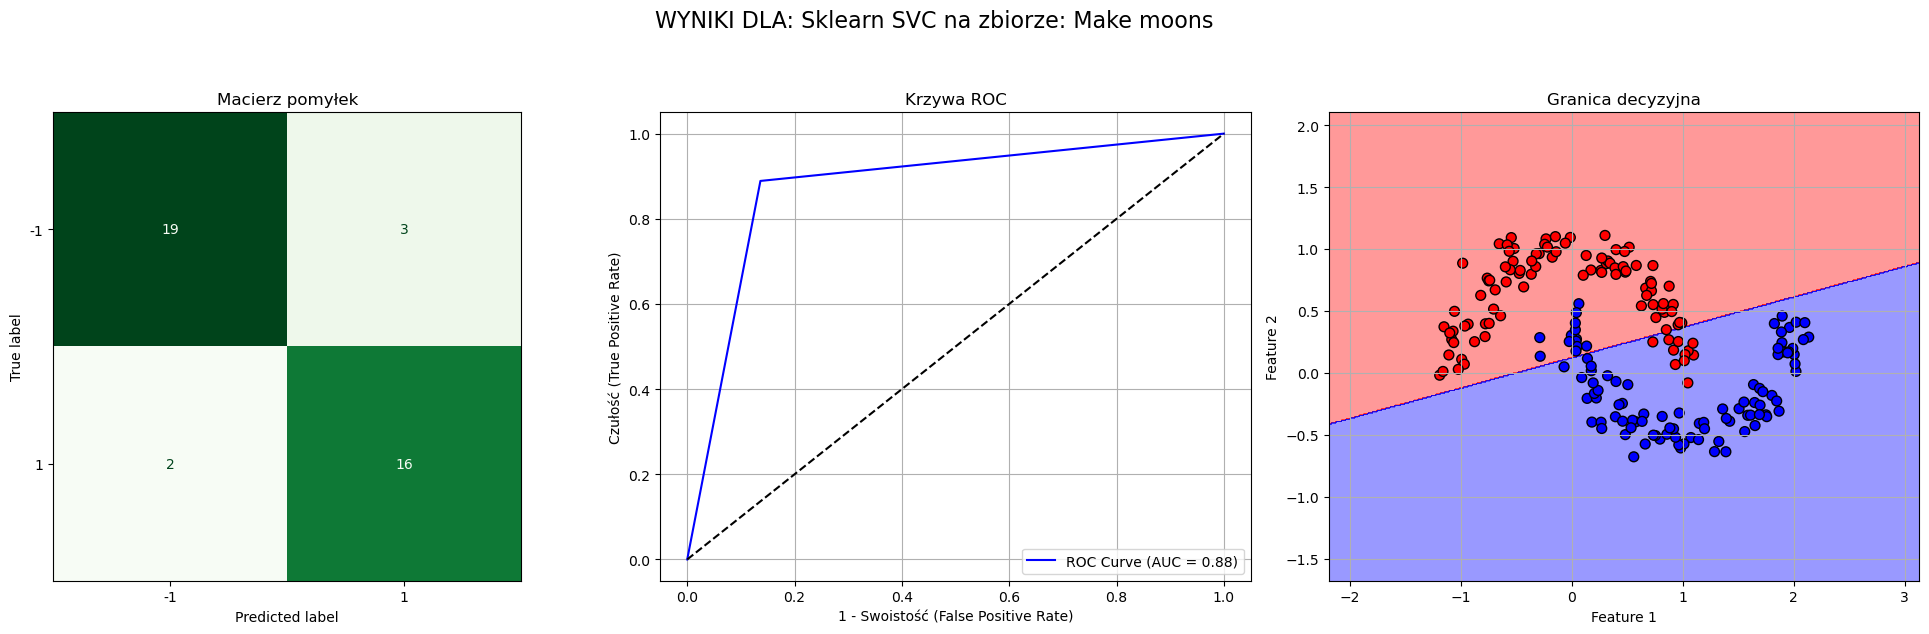

In [146]:
X_moons, y_moons = generate_moons(200, 259195)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_moons = SVM_Linear()
    svm_moons.fit(X_m_train, y_m_train)
    svm_moons_pred = svm_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svm_moons_pred, X_moons, y_moons, svm_moons, "Własna implementacja", "Make moons", [-1, 1])

start = time.time()
for _ in range(10):
    svc_moons = SVC(kernel='linear', random_state=259195)
    svc_moons.fit(X_m_train, y_m_train)
    svc_moons_pred = svc_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svc_moons_pred, X_moons, y_moons, svc_moons, "Sklearn SVC", "Make moons", [-1, 1])


### 3.2 Implementacja SVMa wykorzystującego funkcję jądra 

#### Klasyfikator SVM z wyborem funkcji jądra:

In [147]:
from scipy.optimize import minimize

class SVM: 
    def __init__(self, kernel='linear', learning_rate=0.5, C=1.0, poly_degree=3, gamma=0.5):
        self.lr = learning_rate
        self.kernel = kernel
        self.degree = poly_degree
        self.gamma = gamma
        self.C = C
        self.lambdas = None
        # self.w = None
        self.X = None
        self.y = None
        self.b = None
        self.support_vectors = None

    def kernel_function(self, X1, X2):
        if self.kernel == 'linear':
            return X1 @ X2.T
        elif self.kernel == 'poly':
            return ((X1 @ X2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
            X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
            dist = X1_sq - 2 * X1 @ X2.T + X2_sq
            return np.exp(-self.gamma * dist)
    

    def dual_svm(self, lambdas, X, y):
        K = self.kernel_function(X, X)
        L = np.outer(lambdas, lambdas)
        Y = np.outer(y, y)
        return -np.sum(lambdas) + 0.5 * np.sum(L * Y * K)
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.X = X
        self.y = y

        ## ograniczenia:
        bounds = [(0, self.C) for _ in range(n_samples)] ## lambda >= 0
        constraints = {'type': 'eq', 'fun': lambda l: np.dot(l, y)} ## suma lambd @ y musi być równa 0

        init_lambdas = np.random.rand(n_samples)

        result = minimize(
            fun=self.dual_svm,
            x0=init_lambdas,
            args=(X, y),
            bounds=bounds,
            constraints=constraints,
            method='SLSQP',
            options={'disp': False, 'maxiter': 1000}
        )
        self.lambdas = result.x

        tol = 1e-5
        self.support_vectors = self.lambdas > tol

        margin_sv = (self.lambdas > tol) & (self.lambdas < self.C - tol) # wybieramy punkty z przedziału (0, C) czyli punkty nośne na granicy marginesu
        margin_points = margin_sv if np.any(margin_sv) else self.support_vectors

        sv_y = y[margin_points] 
        K = self.kernel_function(X[margin_points], X[self.support_vectors])
        lambdas_y = self.lambdas[self.support_vectors] * self.y[self.support_vectors]
        self.b = np.mean(sv_y - np.dot(K, lambdas_y)) # b = y_i - K * lambda * y_j -> tylko dla punktów nośnych na marginesie 

        # self.support_vectors = self.lambdas > 1e-5
        # sv_K = self.kernel_function(X[self.support_vectors], X[self.support_vectors])
        # sv_y = y[self.support_vectors]
        # sv_lambdas = self.lambdas[self.support_vectors]
        # self.b = np.mean(
        #     sv_y - np.dot(sv_K, sv_lambdas * sv_y)
        # )

    def prepare_predict(self, X):
        K = self.kernel_function(X, self.X[self.support_vectors])
        l_y = self.lambdas[self.support_vectors] * self.y[self.support_vectors]
        return np.dot(K, l_y) + self.b

    def predict(self, X):
        return np.sign(self.prepare_predict(X))



#### SVM *poly*:

Czas wykonania: 18.0501127243042s.
Własna implementacja Poly na Generate data:
Skuteczność: 95.0000%
Czułość (Recall): 91.6667%
Swoistość: 100.0000%
ROC AUC: 0.9583


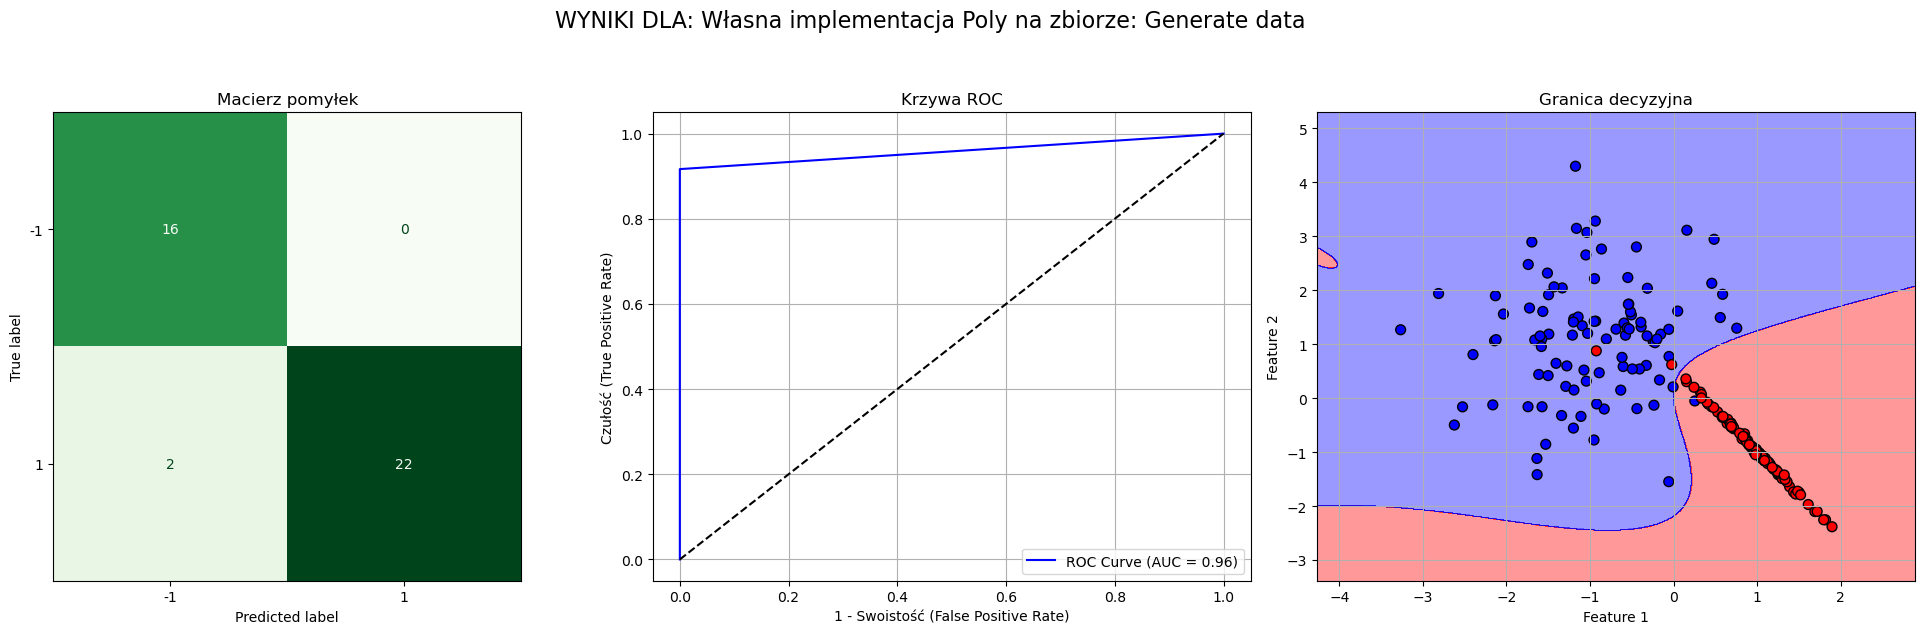

Czas wykonania: 0.01670551300048828s.
Sklearn SVC Poly na Generate Data:
Skuteczność: 87.5000%
Czułość (Recall): 79.1667%
Swoistość: 100.0000%
ROC AUC: 0.8958


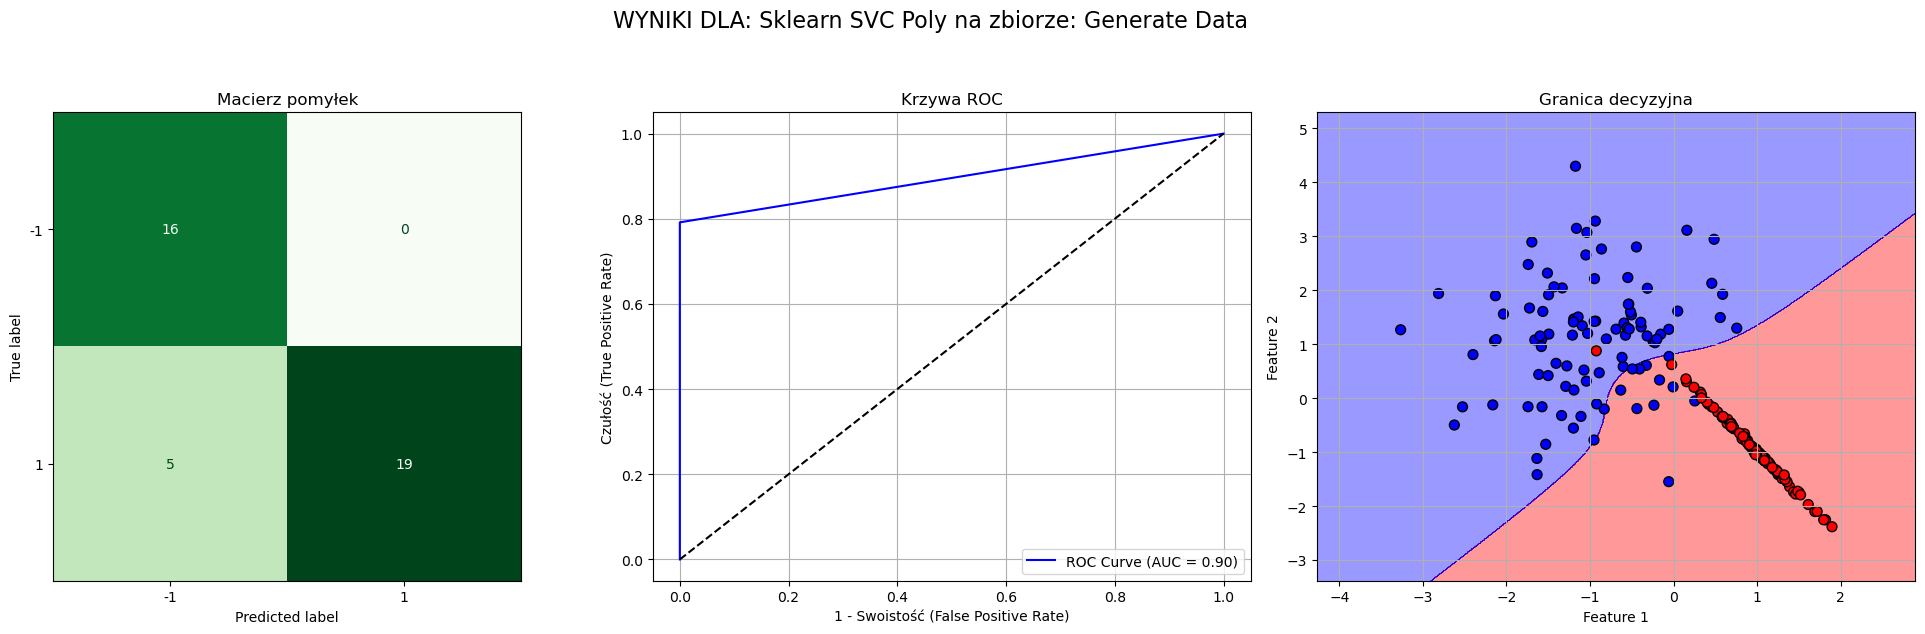

In [148]:
X_generate, y_generate = generate_data(200, 2, 259195)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_generate, y_generate, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_gen = SVM(kernel='poly')
    svm_gen.fit(X_gen_train, y_gen_train)
    svm_generate_pred = svm_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svm_generate_pred, X_generate, y_generate, svm_gen, "Własna implementacja Poly", "Generate data", [-1, 1])

start = time.time()
for _ in range(10):
    svc_gen = SVC(kernel='poly', random_state=259195)
    svc_gen.fit(X_gen_train, y_gen_train)
    svc_generate_pred = svc_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svc_generate_pred, X_generate, y_generate, svc_gen, "Sklearn SVC Poly", "Generate Data", [-1, 1])

Czas wykonania: 26.151697397232056s.
Własna implementacja na Make moons:
Skuteczność: 100.0000%
Czułość (Recall): 100.0000%
Swoistość: 100.0000%
ROC AUC: 1.0000


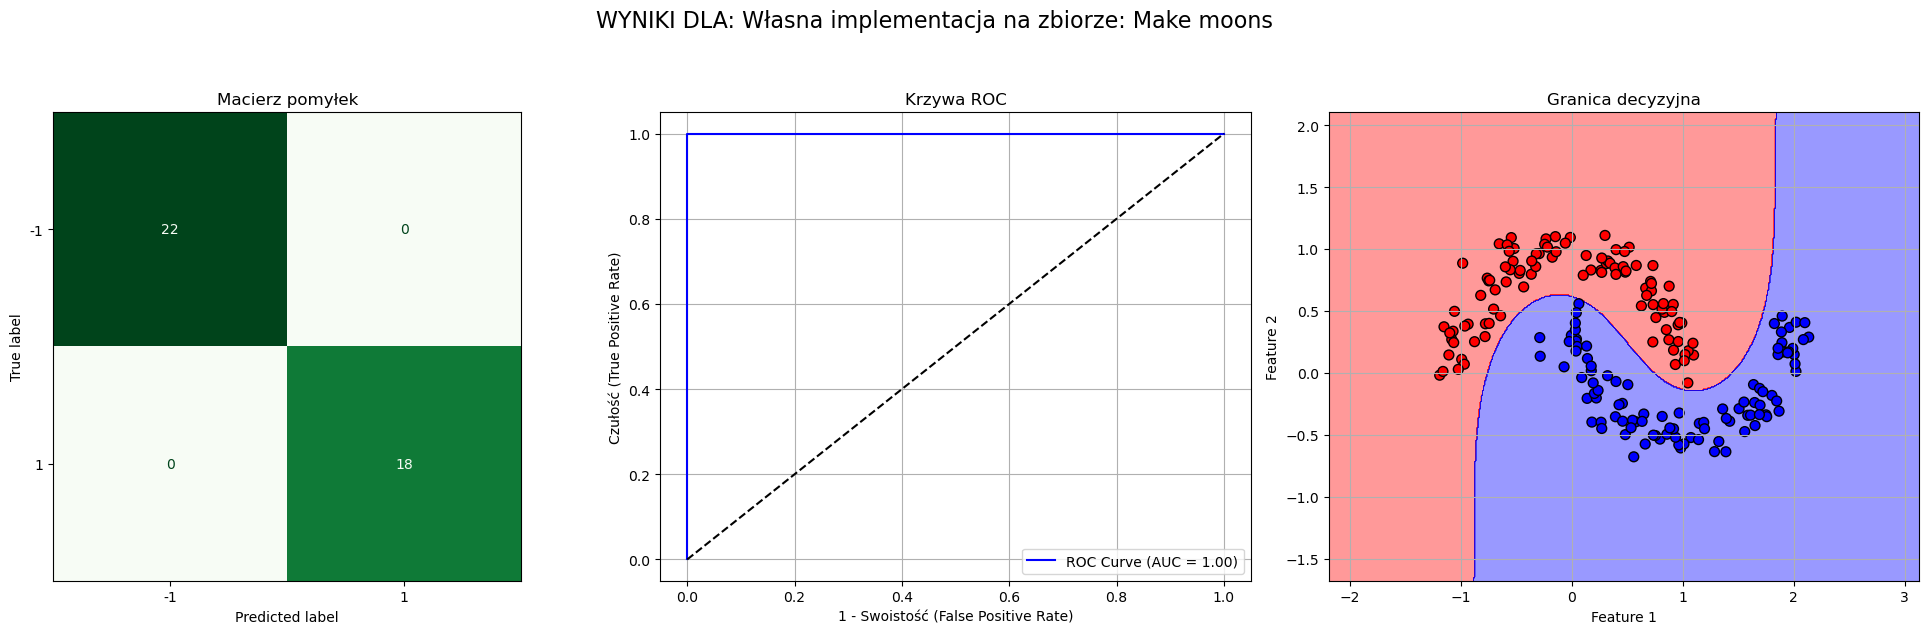

Czas wykonania: 0.022766828536987305s.
Sklearn SVC na Make moons:
Skuteczność: 92.5000%
Czułość (Recall): 100.0000%
Swoistość: 86.3636%
ROC AUC: 0.9318


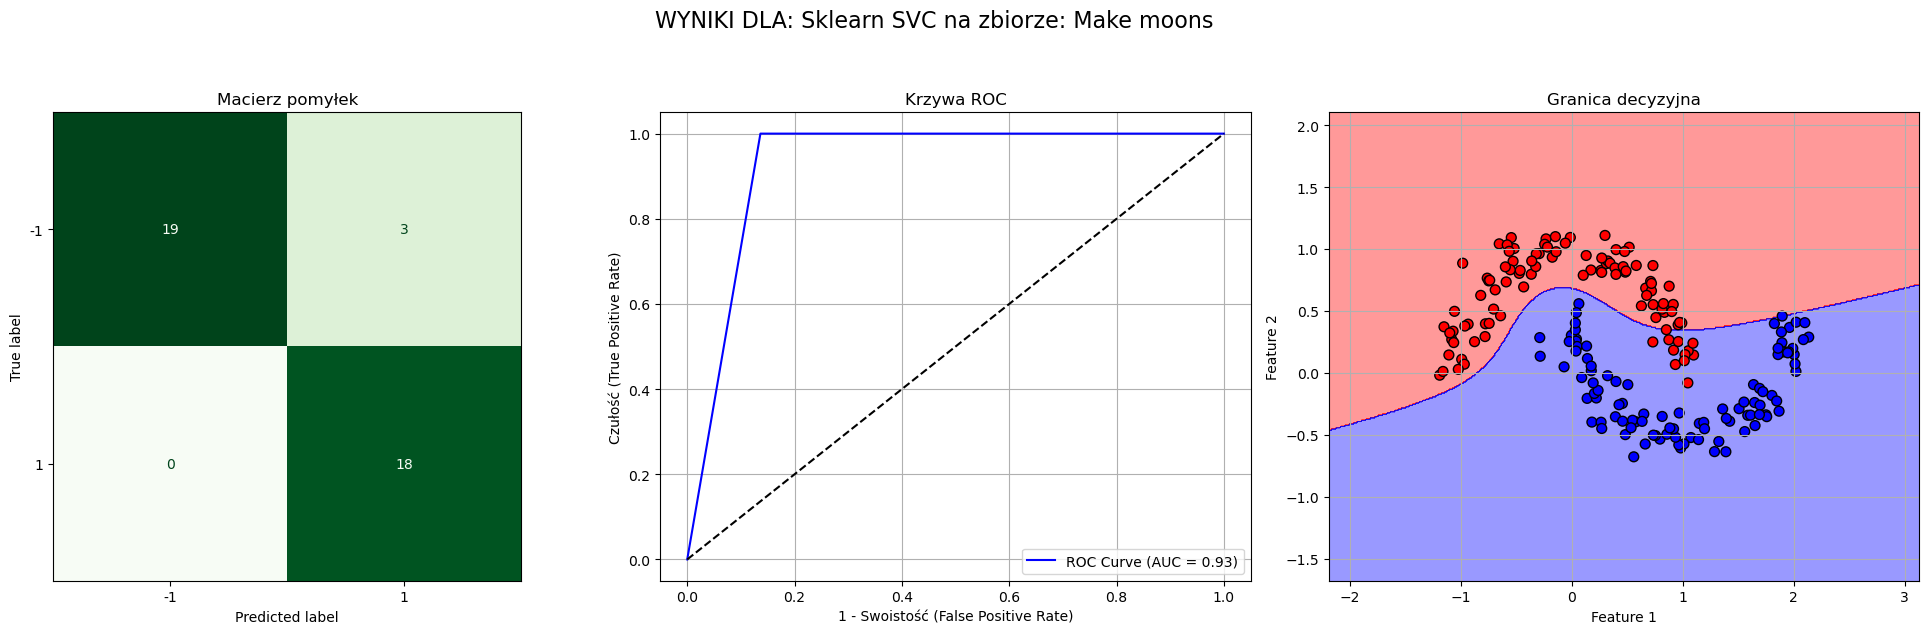

In [149]:
X_moons, y_moons = generate_moons(200, 259195)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_moons = SVM(kernel='poly')
    svm_moons.fit(X_m_train, y_m_train)
    svm_moons_pred = svm_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svm_moons_pred, X_moons, y_moons, svm_moons, "Własna implementacja", "Make moons", [-1, 1])

start = time.time()
for _ in range(10):
    svc_moons = SVC(kernel='poly', random_state=259195)
    svc_moons.fit(X_m_train, y_m_train)
    svc_moons_pred = svc_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svc_moons_pred, X_moons, y_moons, svc_moons, "Sklearn SVC", "Make moons", [-1, 1])

#### SVM *RBF (radial)*:

Czas wykonania: 26.341320991516113s.
Własna implementacja RBF na Generate data:
Skuteczność: 95.0000%
Czułość (Recall): 91.6667%
Swoistość: 100.0000%
ROC AUC: 0.9583


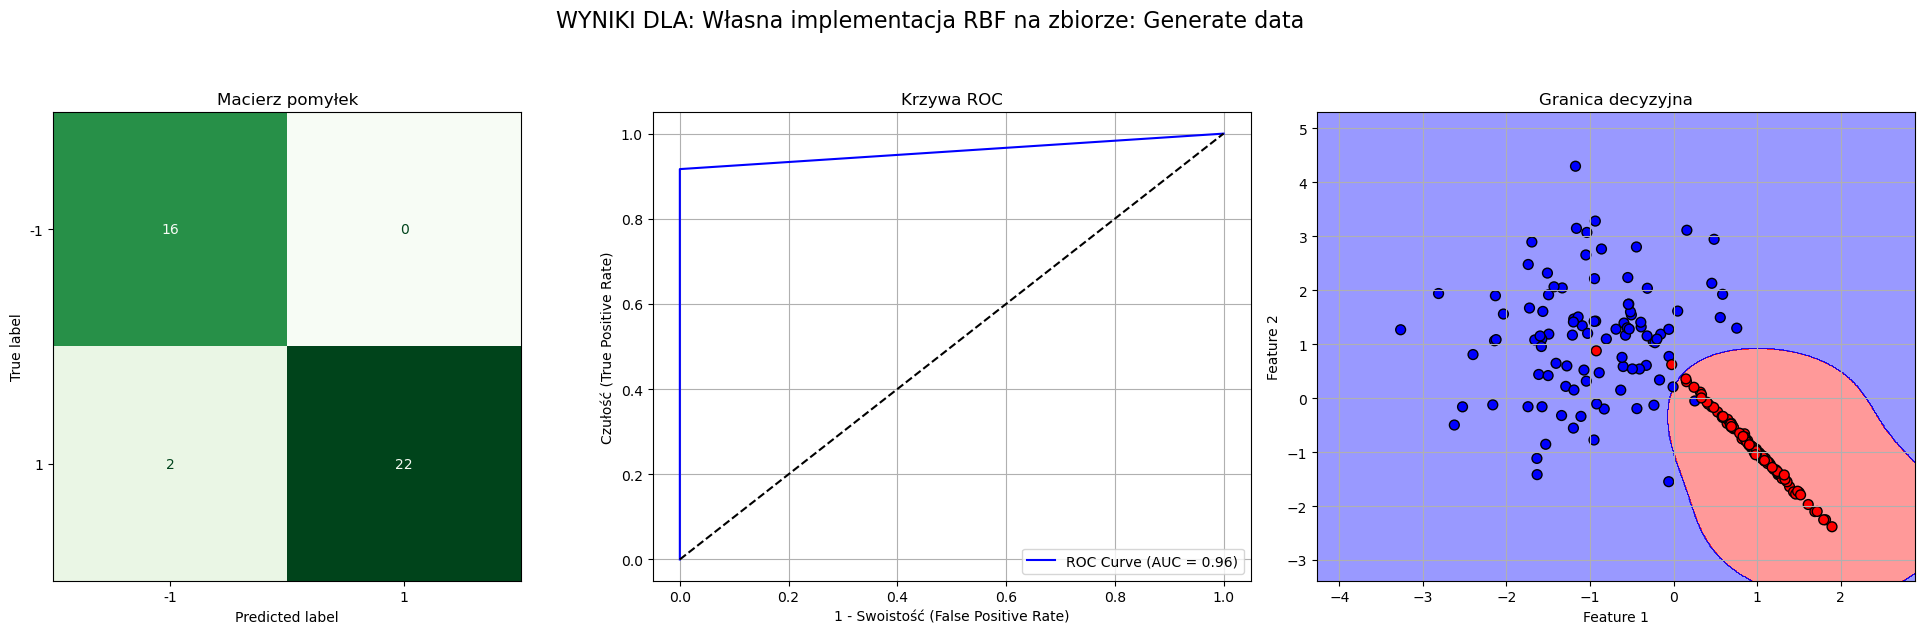

Czas wykonania: 0.01896810531616211s.
Sklearn SVC RBF na Generate Data:
Skuteczność: 92.5000%
Czułość (Recall): 87.5000%
Swoistość: 100.0000%
ROC AUC: 0.9375


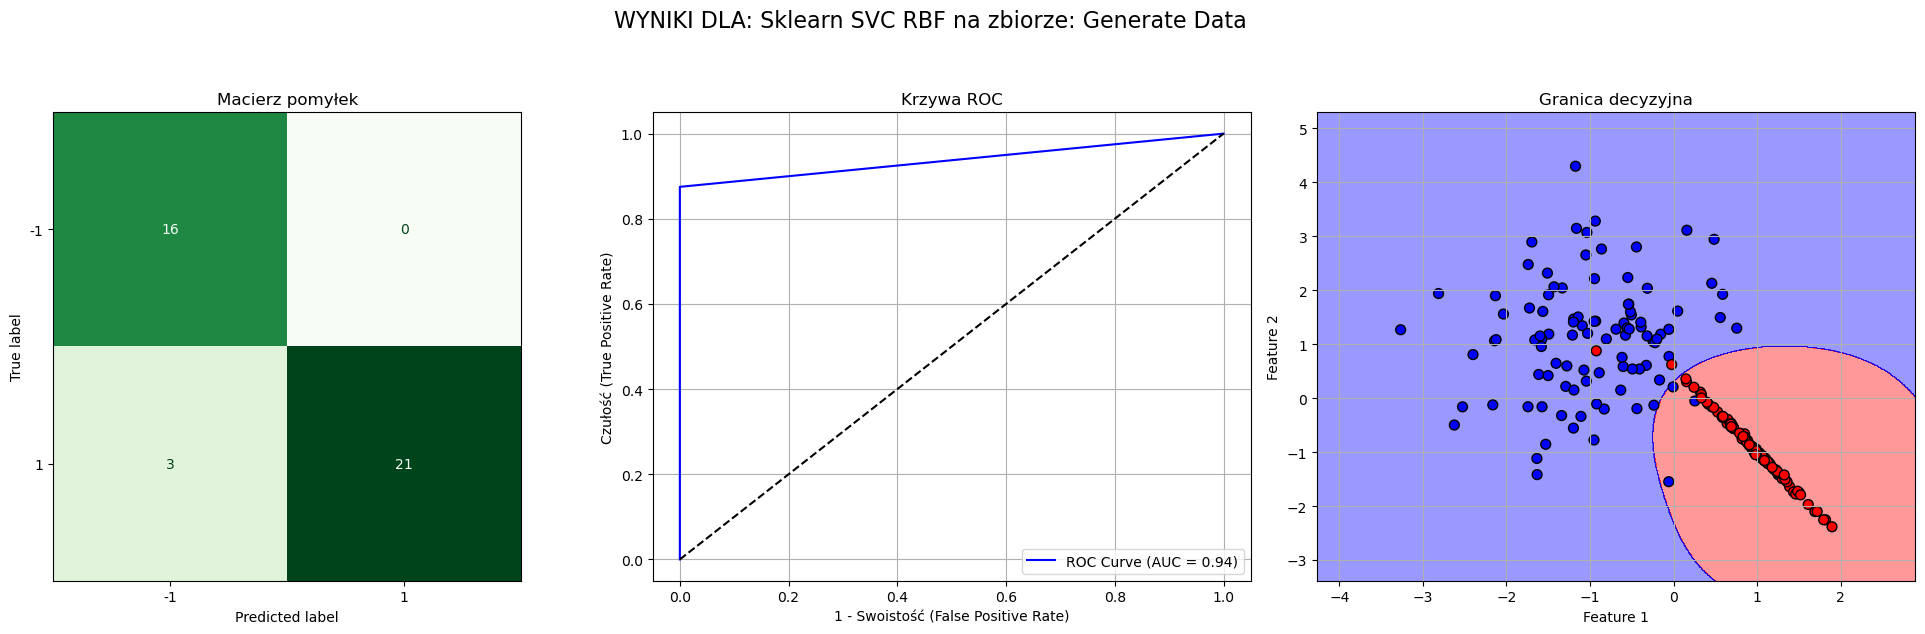

In [150]:
X_generate, y_generate = generate_data(200, 2, 259195)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_generate, y_generate, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_gen = SVM(kernel='rbf')
    svm_gen.fit(X_gen_train, y_gen_train)
    svm_generate_pred = svm_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svm_generate_pred, X_generate, y_generate, svm_gen, "Własna implementacja RBF", "Generate data", [-1, 1])

start = time.time()
for _ in range(10):
    svc_gen = SVC(kernel='rbf', random_state=259195)
    svc_gen.fit(X_gen_train, y_gen_train)
    svc_generate_pred = svc_gen.predict(X_gen_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_gen_test, svc_generate_pred, X_generate, y_generate, svc_gen, "Sklearn SVC RBF", "Generate Data", [-1, 1])

Czas wykonania: 26.647092580795288s.
Własna implementacja RBF na Make moons:
Skuteczność: 97.5000%
Czułość (Recall): 100.0000%
Swoistość: 95.4545%
ROC AUC: 0.9773


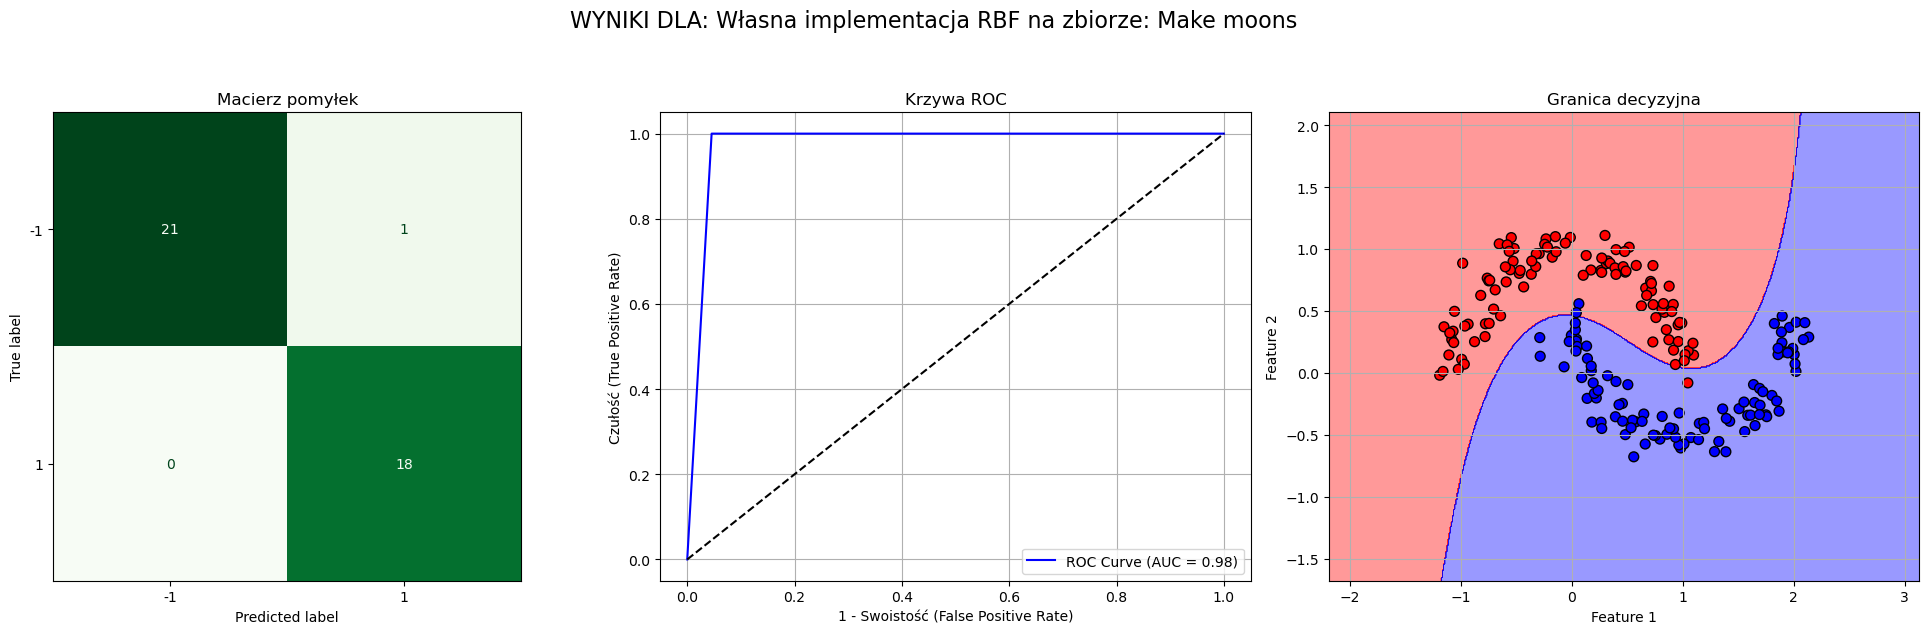

Czas wykonania: 0.010404586791992188s.
Sklearn SVC RBF na Make moons:
Skuteczność: 100.0000%
Czułość (Recall): 100.0000%
Swoistość: 100.0000%
ROC AUC: 1.0000


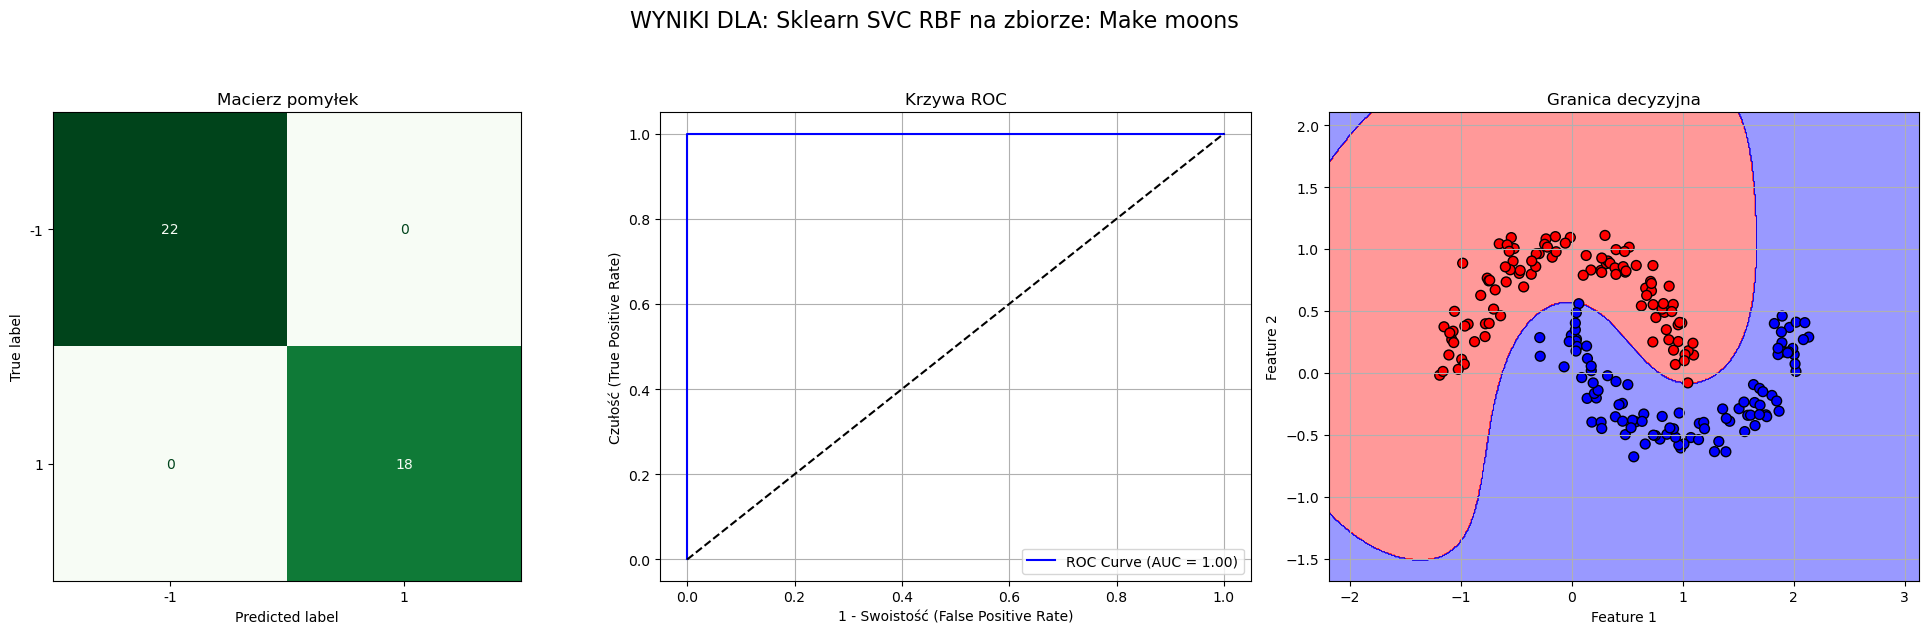

In [151]:
X_moons, y_moons = generate_moons(200, 259195)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(10):
    svm_moons = SVM(kernel='rbf')
    svm_moons.fit(X_m_train, y_m_train)
    svm_moons_pred = svm_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svm_moons_pred, X_moons, y_moons, svm_moons, "Własna implementacja RBF", "Make moons", [-1, 1])

start = time.time()
for _ in range(10):
    svc_moons = SVC(kernel='rbf', random_state=259195)
    svc_moons.fit(X_m_train, y_m_train)
    svc_moons_pred = svc_moons.predict(X_m_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_m_test, svc_moons_pred, X_moons, y_moons, svc_moons, "Sklearn SVC RBF", "Make moons", [-1, 1])

### Obserwacje i wnioski:

* Funkcje jądra wielomianu oraz radialne pozwalają na lepszą klasyfikację od liniowego rozwiązania
* Wyniki są porównywalne do gotowych metod od *sklearn*.

### 3.3 Analiza zbioru SDSS17 w oparciu o SVM

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

#### Wczytanie danych oraz usunięcie nieistotnych kolumn:

In [153]:
data = pd.read_csv('star_classification_SDSS17.csv')

data = data.drop(columns=['cam_col', 'MJD'] + [col for col in data.columns if col.endswith('_ID')])
data.head(10)

,alpha,delta,u,g,r,i,z,class,redshift,plate
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121
5,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,QSO,1.424659,5026
6,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,QSO,0.586455,11069
7,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,GALAXY,0.477009,6183
8,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,GALAXY,0.660012,6625
9,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,STAR,-0.000008,2444


#### Sprawdzenie ilości pustych danych:

In [154]:
num_cols = data.select_dtypes(include=np.number).columns
cat_cols = data.select_dtypes(exclude=np.number).columns

for col in num_cols:
    print(f"{col}: {(data[col].isnull()).sum()}")

for col in cat_cols:
    print(f"{col}: {(data[col].isnull()).sum()}")

alpha: 0
delta: 0
u: 0
g: 0
r: 0
i: 0
z: 0
redshift: 0
plate: 0
class: 0


#### Modyfikacja kolumny *class* - usunięcie QSO:

In [ ]:
data = data[data['class'].isin(['STAR', 'GALAXY'])]
data['class'] = data['class'].map({'STAR': 1, 'GALAXY': -1})

_class = data['class']
data = data.drop(columns=['class'])

# Przeniesienie kolumny 'class' na koniec
data['class'] = _class

print("Klasy:", np.unique(data['class']))

Klasy: [-1  1]


#### Macierz korelacji między danymi:

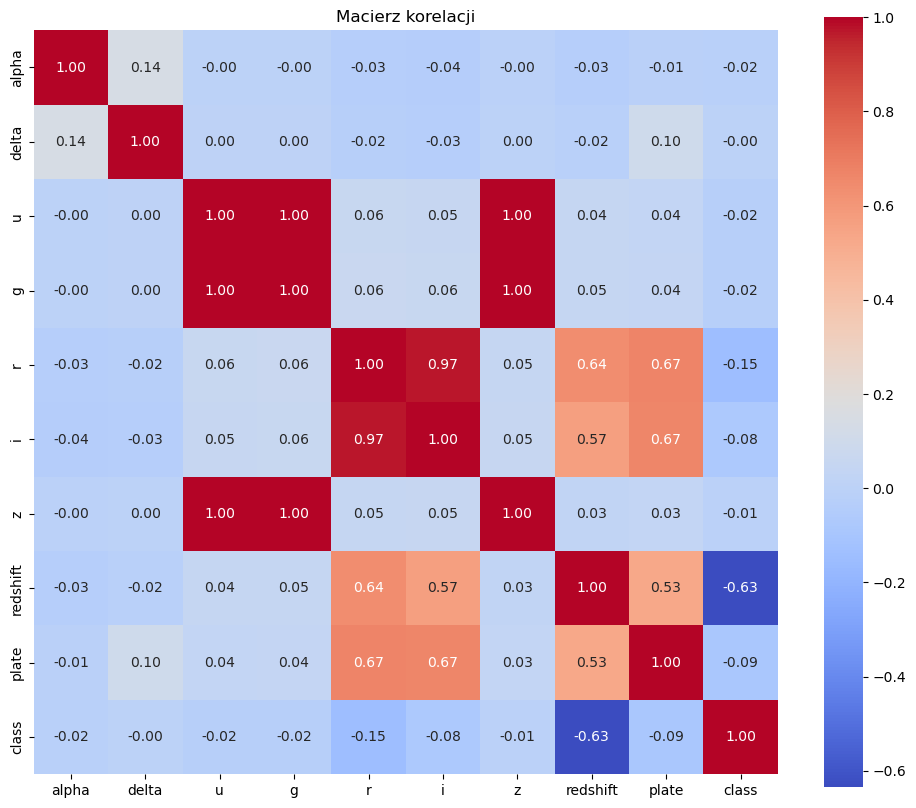

In [156]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Macierz korelacji")
plt.show()

Jak widzimy, najlepiej skorelowanymi cechami z końcową klasyfikacją ma kolumna *redshift*.
Zachodzi również mocna korelacja między kategoriami *z, u, g*, zatem usuniemy dwie z nich.

In [157]:
data.drop(columns=['u', 'g'], inplace=True)

#### Podział na zbiory treningowe i testowe:

In [158]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=259195, stratify=y)
print(f"Rozmiar zbioru treningowego: {X_train.shape[0]}")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]}")
print(f"Y: {y_train.value_counts()}")

Rozmiar zbioru treningowego: 64831
Rozmiar zbioru testowego: 16208
Y: class
-1    47556
 1    17275
Name: count, dtype: int64


#### Normalizacja danych:

In [159]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.head(10)

,alpha,delta,r,i,z,redshift,plate
0,0.012755,0.102976,0.525068,0.479698,0.506472,0.245138,0.560541
1,0.622048,0.237987,0.577873,0.578048,0.644836,0.004910,0.373829
2,0.603451,0.709545,0.600954,0.530851,0.569128,0.406970,0.550851
3,0.132877,0.178436,0.395217,0.369417,0.383846,0.108090,0.011888
4,0.020300,0.214751,0.400690,0.374323,0.387601,0.122453,0.328638
5,0.567169,0.546077,0.344520,0.321015,0.337570,0.035097,0.149418
6,0.607667,0.212974,0.368740,0.353775,0.378146,0.082734,0.021904
7,0.103214,0.149628,0.473093,0.430748,0.443837,0.233445,0.335559
8,0.510806,0.413370,0.391979,0.370624,0.388172,0.066431,0.193714
9,0.670185,0.514156,0.349656,0.332820,0.346376,0.034895,0.093885


#### Przeprowadzenie symulacji dla różnych parametrów *C* oraz **funkcji jądra**:

In [160]:
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

grid = GridSearchCV(SVC(), params, cv=2, scoring='accuracy')
grid.fit(X_train, y_train)

print("Najlepsze parametry:", grid.best_params_)

Najlepsze parametry: {'C': 10, 'kernel': 'poly'}


In [161]:
print(f"Najlepsza dokładność: {grid.best_score_*100:.2f} %")
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

Najlepsza dokładność: 99.21 %


SVC na Star classification:
Skuteczność: 99.3398%
Czułość (Recall): 99.9768%
Swoistość: 99.1084%
ROC AUC: 0.9954


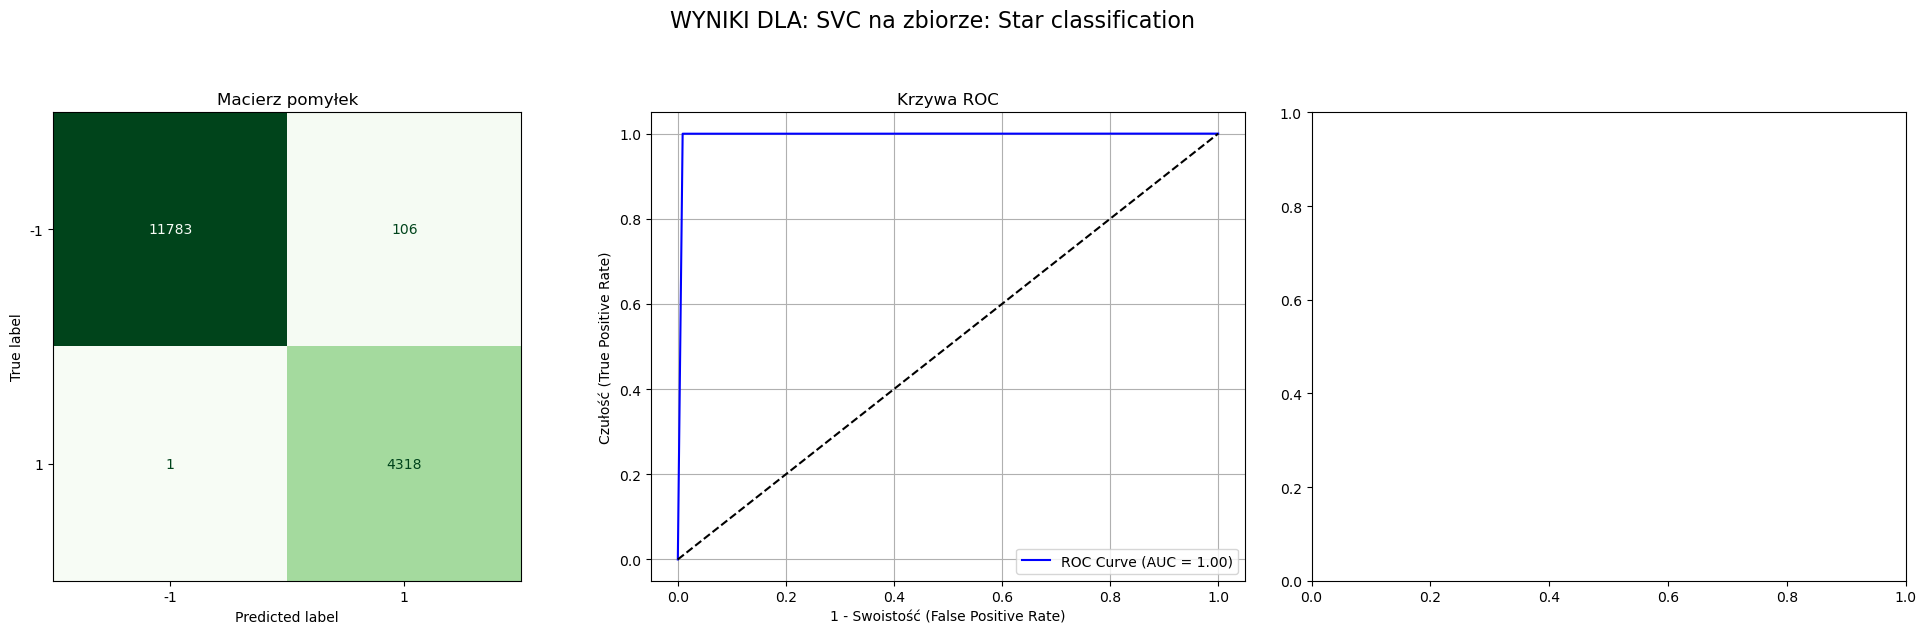

In [162]:
evaluate_classifier(y_test, y_pred, X, y, best_model, "SVC", "Star classification", [-1, 1], decision_plot=False)